# Likelihood fit

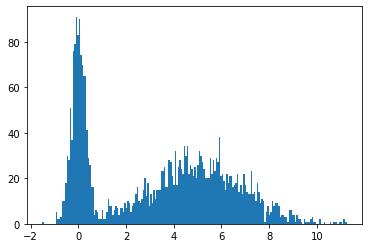

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

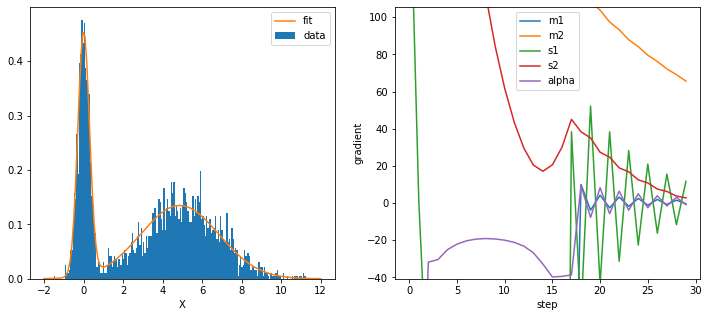

In [4]:
import tensorflow as tf
from IPython.display import clear_output

# Defining Gaussian PDF using tf functions
def gaussian(x, mu, sigma):
  return tf.exp(-0.5*(x-mu)**2/sigma**2)/(sigma*(2*np.pi)**0.5) # use tf.exp for the exponent, don't forget the normalization

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = tf.Variable(1.0)
m2    = tf.Variable(4.0)
s1    = tf.Variable(1.0)
s2    = tf.Variable(1.0)
alpha = tf.Variable(0.5)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  if (m1<0 or m2<0):
    print('Error mu')
  if (s1<10**(-5) or s2<10**(-5)):
    print('Error s')
              # ensure the sigmas are positive (greater or equal to some small
              # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
              # hint: use the `assign` method to update the variable values


variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  return tf.math.log(model_pdf(x)) # hint: the logarithm is in tf.math.log

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  with tf.GradientTape() as t:
    # NOTE: if `variable` was created with `trainable=False`, you need to
    # manually add it to the tape by calling `t.watch(variable)`. By default
    # the variable are created with `trainable=True`

    # Forward pass:
    l = loglike(X)
  
  # Backprop:
  grads =  t.gradient(l,variables)# Calculate the gradients
  grad_history.append([g.numpy() for g in grads])
  # Gradient ascent step:
  for j in range(len(variables)):
    variables[j].assign_add(learning_rate*grads[j].numpy())
              # Apply the gradients manually (add
              # `learning_rate * corresponding_gradient` to
              # each variable)
  apply_constraints()

  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);